In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.transforms import functional as F
from albumentations import Compose, Normalize, HorizontalFlip, RandomCrop
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:

# --- Параметры ---
IMAGE_DIR = "/kaggle/input/apollo-scape/apollo_scape/ColorImage"
LABEL_DIR = "/kaggle/input/apollo-scape/apollo_scape/Label"
BATCH_SIZE = 4
NUM_CLASSES = 2  # Два класса: разметка или нет разметки
NUM_EPOCHS = 25
ACCUMULATION_STEPS = 4  # Для градиентного накопления
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [3]:

# --- Анализ уникальных классов в масках ---
def analyze_mask_classes(label_dir):
    all_classes = set()
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        mask = np.array(Image.open(label_path))
        unique_classes = np.unique(mask)
        all_classes.update(unique_classes)
    return sorted(list(all_classes))

# Вывод уникальных классов в масках
classes = analyze_mask_classes(LABEL_DIR)
print(f"Уникальные классы в масках: {classes}")


Уникальные классы в масках: [0, 200, 201, 202, 204, 205, 206, 207, 209, 210, 212, 213, 214, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 230, 250, 255]


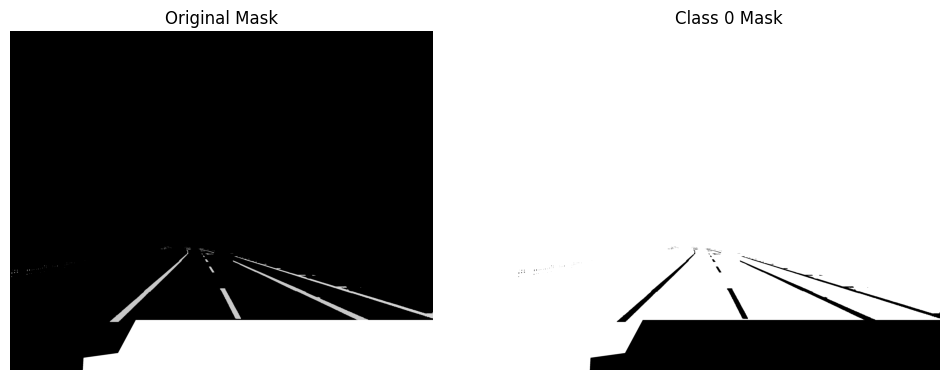

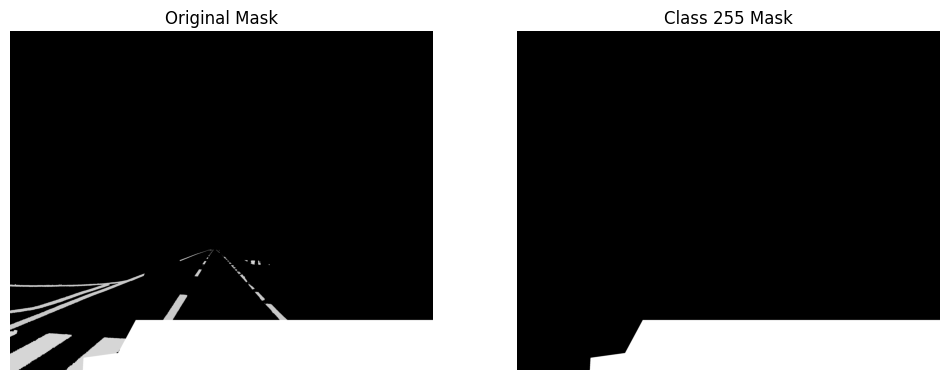

In [39]:
import random

# Function to visualize a mask for a specific class
def visualize_mask_class(label_dir, class_value):
    # Randomly select a label file
    label_files = os.listdir(label_dir)
    label_file = random.choice(label_files)
    label_path = os.path.join(label_dir, label_file)

    # Load the mask image
    mask = np.array(Image.open(label_path))

    # Create a binary mask for the specific class
    class_mask = (mask == class_value).astype(np.uint8) * 255

    # Plot the original mask and the class-specific mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(mask, cmap='gray')
    ax[0].set_title('Original Mask')
    ax[0].axis('off')

    ax[1].imshow(class_mask, cmap='gray')
    ax[1].set_title(f'Class {class_value} Mask')
    ax[1].axis('off')

    plt.show()

# опытным путем понимаем, что все то, что не является дорожной разметкой - 0 класс
# также еще машина - 255 класс
visualize_mask_class(LABEL_DIR, class_value=0)


In [40]:

# --- Кастомный Dataset ---
class ApolloScapeDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.label_files = self._filter_valid_files(self.image_files, label_dir)
        self.transform = transform

    def _filter_valid_files(self, image_files, label_dir):
        """
        Фильтрует список файлов, оставляя только те, для которых существует соответствующий файл метки.
        """
        valid_files = []
        for image_file in image_files:
            label_file = os.path.splitext(image_file)[0] + "_bin.png"
            label_path = os.path.join(label_dir, label_file)
            if os.path.exists(label_path):
                valid_files.append(image_file)
        return valid_files

    def __len__(self):
        return len(self.label_files)

    def __getitem__(self, idx):
        image_file = self.label_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        label_file = os.path.splitext(image_file)[0] + "_bin.png"
        label_path = os.path.join(self.label_dir, label_file)

        # Загрузка изображений и меток
        image = np.array(Image.open(image_path).convert("RGB"))
        label = np.array(Image.open(label_path))

        # Преобразование метки в бинарный формат
        label = self._convert_to_binary_mask(label)

        # Применение трансформаций
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented["image"]
            label = augmented["mask"]

        return image, label.long()

    @staticmethod
    def _convert_to_binary_mask(label):
        """
        Преобразует маску в бинарный формат:
        - Все пиксели дорожной разметки становятся 1.
        - Остальные пиксели становятся 0.
        """
        road_marking_classes = [200, 201, 202, 204, 205, 206, 207, 209, 210, 212, 213, 214, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 230, 250]
        binary_mask = np.isin(label, road_marking_classes).astype(np.uint8)
        return binary_mask


In [ ]:

# --- Аугментации ---
train_transform = Compose([
    HorizontalFlip(p=0.5),
    RandomCrop(512, 512),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = Compose([
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


In [42]:

# --- Датасеты и DataLoader ---
train_dataset = ApolloScapeDataset(IMAGE_DIR, LABEL_DIR, transform=train_transform)
val_dataset = ApolloScapeDataset(IMAGE_DIR, LABEL_DIR, transform=val_transform)

print(f"Размер тренировочного датасета: {len(train_dataset)}")
print(f"Размер валидационного датасета: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Размер тренировочного датасета: 2791
Размер валидационного датасета: 2791


In [43]:
# import os

# # Проверим для каждого .jpg изображения, есть ли соответствующая метка
# for image_file in sorted(os.listdir(IMAGE_DIR)):
#     if image_file.endswith(".jpg"):  # Фильтруем только файлы .jpg
#         label_file = os.path.splitext(image_file)[0] + "_bin.png"  # Формируем имя метки
#         label_path = os.path.join(LABEL_DIR, label_file)
        
#         # Проверяем, существует ли метка
#         if os.path.exists(label_path):
#             print(f"Для изображения {image_file} существует метка {label_file}")


In [44]:

# --- Модель ---
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model.to(DEVICE)

# --- Оптимизатор и функция потерь ---
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 203MB/s] 


In [45]:

# --- Обучающий цикл ---
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            running_loss += loss.item()
    return running_loss / len(loader)


In [ ]:
# --- Для смешанной точности ---
scaler = torch.amp.GradScaler("cuda")

# --- Основной цикл обучения ---
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    torch.cuda.empty_cache()  # Освобождение памяти перед каждой эпохой
    model.train()
    
    # --- Обучение ---
    train_loss = 0.0
    optimizer.zero_grad()
    for i, (images, masks) in enumerate(tqdm(train_loader, desc="Training")):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        # Смешанная точность
        with torch.amp.autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs["out"], masks)
            loss = loss / ACCUMULATION_STEPS  # Учет накопления

        # Обратное распространение
        scaler.scale(loss).backward()

        # Обновление градиентов каждые ACCUMULATION_STEPS шагов
        if (i + 1) % ACCUMULATION_STEPS == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item() * ACCUMULATION_STEPS

    train_loss /= len(train_loader)
    print(f"Train Loss: {train_loss:.4f}")

    # --- Валидация каждые 5 эпох ---
    if (epoch + 1) % 5 == 0:
        print("Starting validation on 100 images...")
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (images, masks) in enumerate(tqdm(val_loader, desc="Validation")):
                if i >= 100:  # Проверяем только на первых 100 батчах
                    break
                images, masks = images.to(DEVICE), masks.to(DEVICE)

                with torch.amp.autocast("cuda"):
                    outputs = model(images)
                    loss = criterion(outputs["out"], masks)

                val_loss += loss.item()

        val_loss /= min(len(val_loader), 100)
        print(f"Val Loss: {val_loss:.4f}")

    # --- Сохранение модели каждые 5 эпох ---
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"deeplabv3p_epoch{epoch + 1}.pth")

# --- Финальное сохранение модели ---
torch.save(model.state_dict(), "deeplabv3p_final.pth")


Epoch 1/25


Training: 100%|██████████| 698/698 [14:43<00:00,  1.27s/it]


Train Loss: 0.0928
Epoch 2/25


Training: 100%|██████████| 698/698 [12:13<00:00,  1.05s/it]


Train Loss: 0.0600
Epoch 3/25


Training: 100%|██████████| 698/698 [12:11<00:00,  1.05s/it]


Train Loss: 0.0523
Epoch 4/25


Training: 100%|██████████| 698/698 [12:10<00:00,  1.05s/it]


Train Loss: 0.0455
Epoch 5/25


Training: 100%|██████████| 698/698 [12:10<00:00,  1.05s/it]


Train Loss: 0.0460
Starting validation on 100 images...


Validation:  14%|█▍        | 100/698 [12:44<1:16:10,  7.64s/it]


Val Loss: 0.0467
Epoch 6/25


Training: 100%|██████████| 698/698 [11:55<00:00,  1.03s/it]


Train Loss: 0.0416
Epoch 7/25


Training: 100%|██████████| 698/698 [11:51<00:00,  1.02s/it]


Train Loss: 0.0417
Epoch 8/25


Training: 100%|██████████| 698/698 [11:45<00:00,  1.01s/it]


Train Loss: 0.0359
Epoch 9/25


Training: 100%|██████████| 698/698 [11:47<00:00,  1.01s/it]


Train Loss: 0.0360
Epoch 10/25


Training: 100%|██████████| 698/698 [11:44<00:00,  1.01s/it]


Train Loss: 0.0337
Starting validation on 100 images...


Validation:  14%|█▍        | 100/698 [11:50<1:10:48,  7.10s/it]


Val Loss: 0.0250
Epoch 11/25


Training: 100%|██████████| 698/698 [11:31<00:00,  1.01it/s]


Train Loss: 0.0341
Epoch 12/25


Training: 100%|██████████| 698/698 [11:17<00:00,  1.03it/s]


Train Loss: 0.0377
Epoch 13/25


Training: 100%|██████████| 698/698 [12:33<00:00,  1.08s/it]


Train Loss: 0.0377
Epoch 14/25


Training: 100%|██████████| 698/698 [12:05<00:00,  1.04s/it]


Train Loss: 0.0316
Epoch 15/25


Training: 100%|██████████| 698/698 [11:26<00:00,  1.02it/s]


Train Loss: 0.0345
Starting validation on 100 images...


Validation:  14%|█▍        | 100/698 [11:44<1:10:12,  7.04s/it]


Val Loss: 0.0211
Epoch 16/25


Training: 100%|██████████| 698/698 [11:24<00:00,  1.02it/s]


Train Loss: 0.0312
Epoch 17/25


Training: 100%|██████████| 698/698 [11:16<00:00,  1.03it/s]


Train Loss: 0.0313
Epoch 18/25


Training: 100%|██████████| 698/698 [11:17<00:00,  1.03it/s]


Train Loss: 0.0305
Epoch 19/25


Training: 100%|██████████| 698/698 [11:16<00:00,  1.03it/s]


Train Loss: 0.0335
Epoch 20/25


Training: 100%|██████████| 698/698 [11:05<00:00,  1.05it/s]


Train Loss: 0.0307
Starting validation on 100 images...


Validation:  14%|█▍        | 100/698 [11:26<1:08:27,  6.87s/it]


Val Loss: 0.0193
Epoch 21/25


Training: 100%|██████████| 698/698 [11:04<00:00,  1.05it/s]


Train Loss: 0.0337
Epoch 22/25


Training: 100%|██████████| 698/698 [11:08<00:00,  1.04it/s]


Train Loss: 0.0369
Epoch 23/25


Training: 100%|██████████| 698/698 [11:07<00:00,  1.05it/s]


Train Loss: 0.0305
Epoch 24/25


Training: 100%|██████████| 698/698 [11:16<00:00,  1.03it/s]


Train Loss: 0.0297
Epoch 25/25


Training: 100%|██████████| 698/698 [11:20<00:00,  1.03it/s]


Train Loss: 0.0290
Starting validation on 100 images...


Validation:  14%|█▍        | 100/698 [11:35<1:09:18,  6.95s/it]


Val Loss: 0.0181


In [47]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [58]:
from torchvision import transforms
model.to(DEVICE)
model.eval()

# --- Преобразование тестового изображения ---
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Приведение изображения к фиксированному размеру
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

image = Image.open('/kaggle/input/apollo-scape/apollo_scape/ColorImage/170927_063829782_Camera_6.jpg').convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(DEVICE)


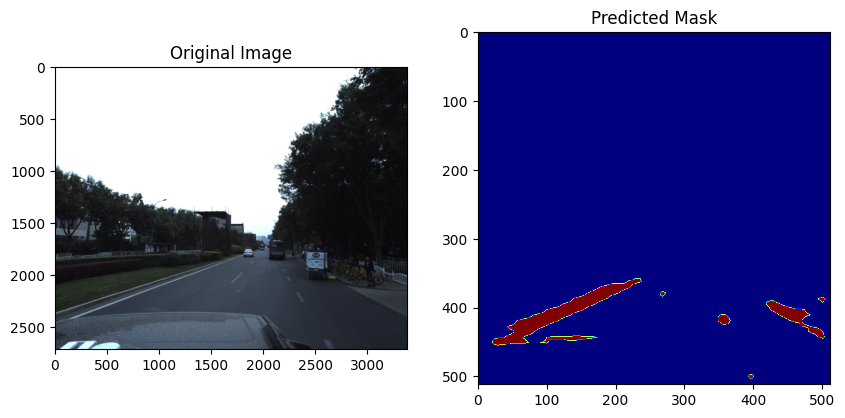

In [52]:

# --- Прогнозирование ---
with torch.no_grad():
    with torch.amp.autocast("cuda"):
        output = model(input_tensor)["out"]
pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# --- Отображение результатов ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap="jet")
plt.show()


In [53]:
from IPython.display import FileLink
FileLink(r'deeplabv3p_epoch25.pth')

/kaggle/working/deeplabv3p_epoch25.pth